In [1]:
print ("Hello World")

Hello World


> On Unix, you can uncomment the cell below to download the data and setup the expected file structure

In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [3]:
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results


/zata/zippy/kresgeb/Miniforge3/envs/main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.15.0 pandas==2.2.2 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [4]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
print(adata)
print(adata.obs_names[:10])
print(adata.var_names[:10])

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1'],
      dtype='object')
Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10'],
      dtype='object')


normalizing counts per cell
    finished (0:00:00)


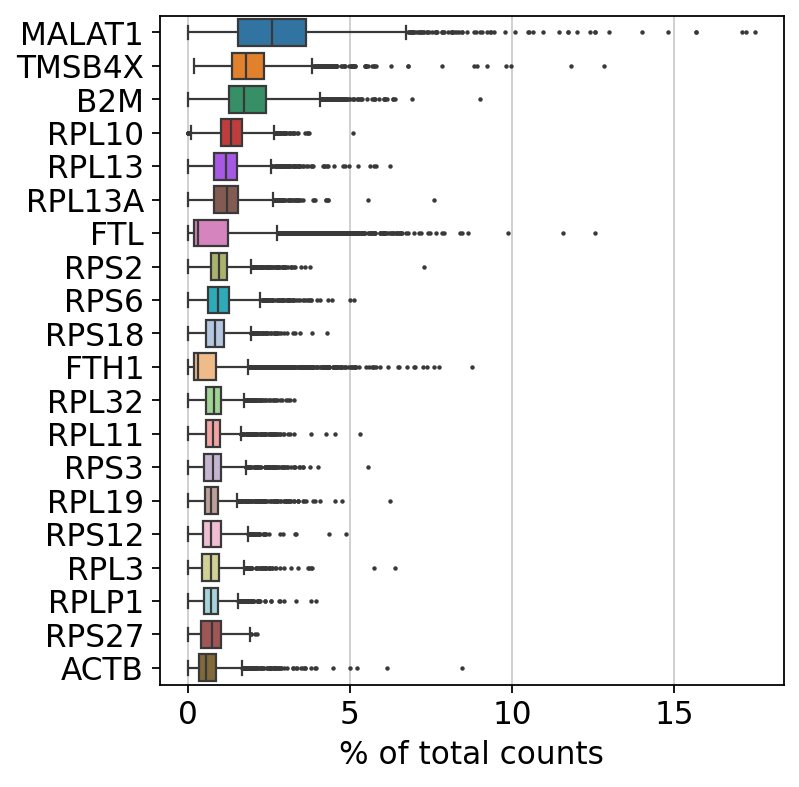

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [8]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

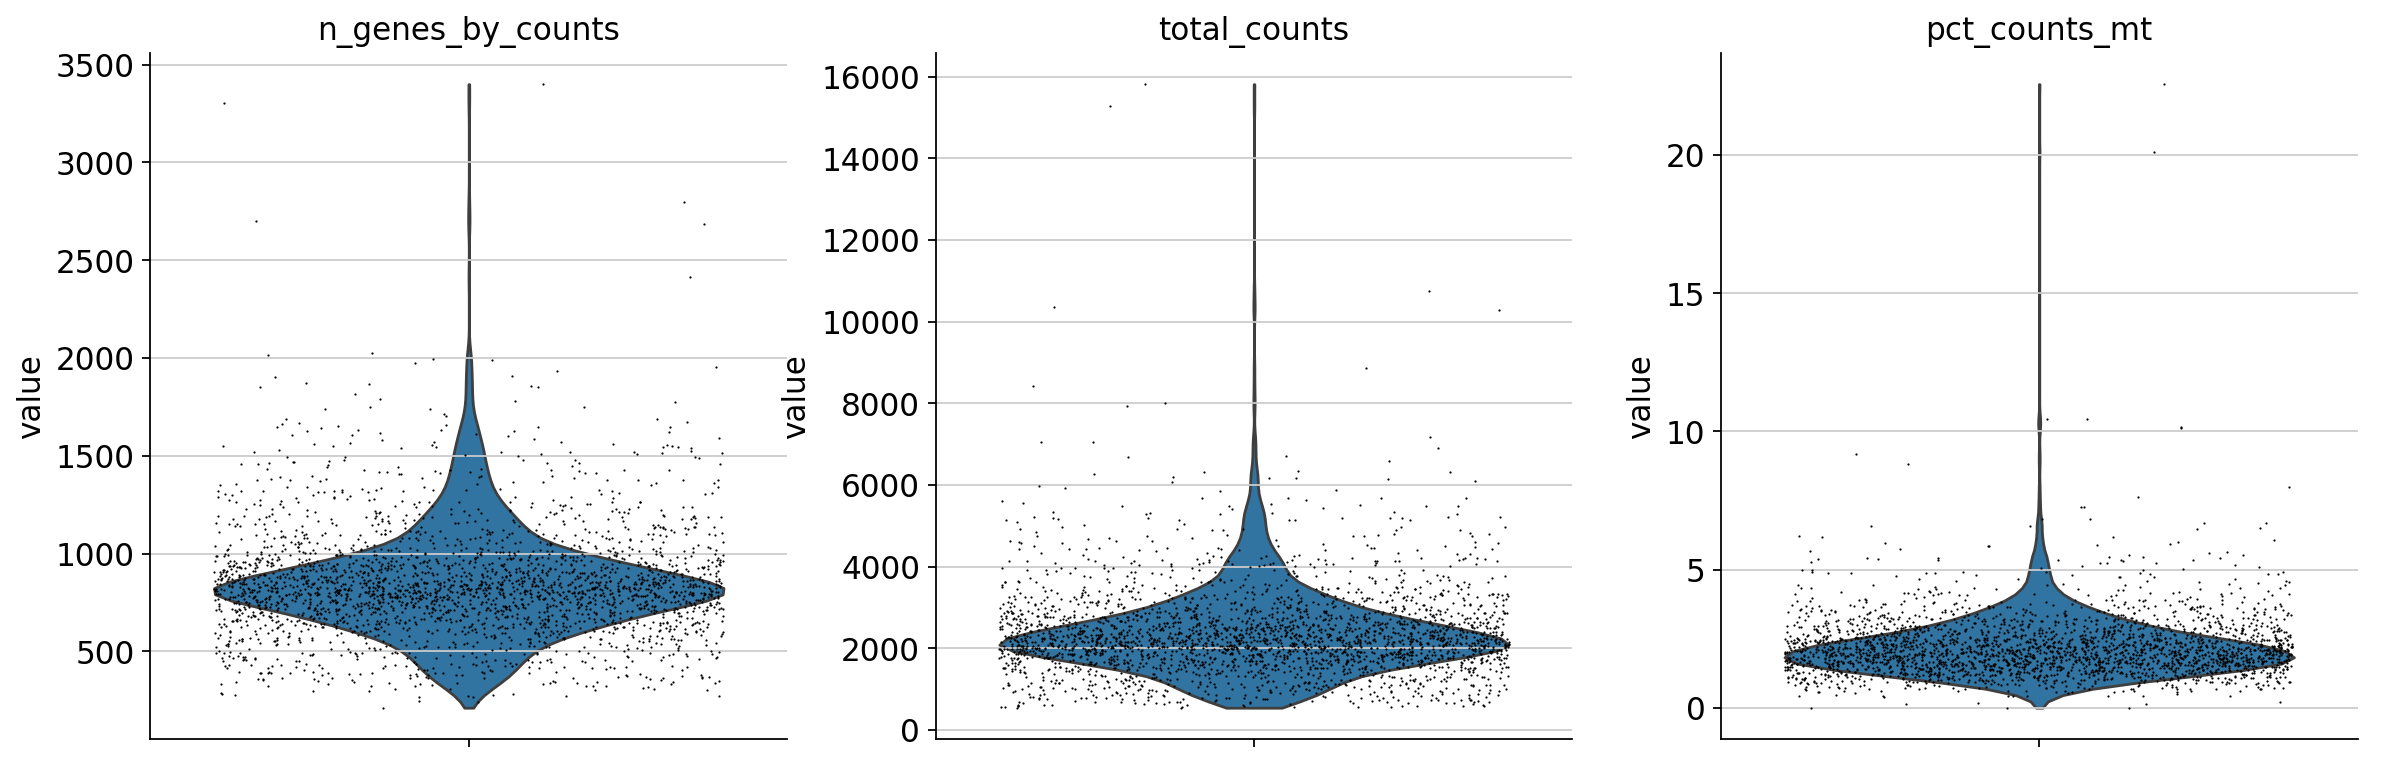

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

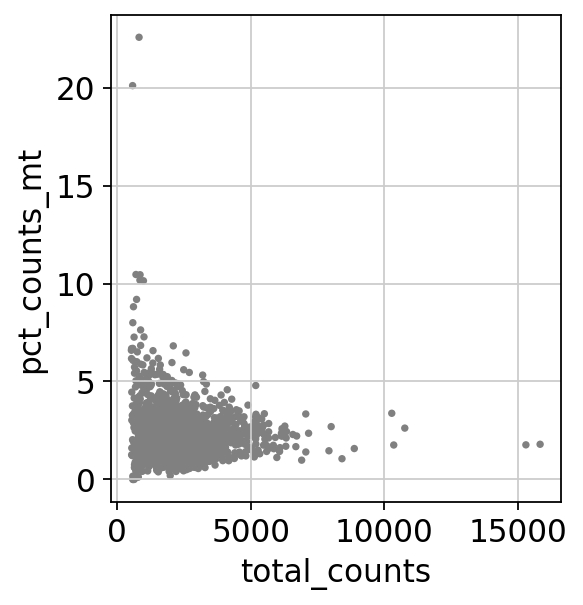

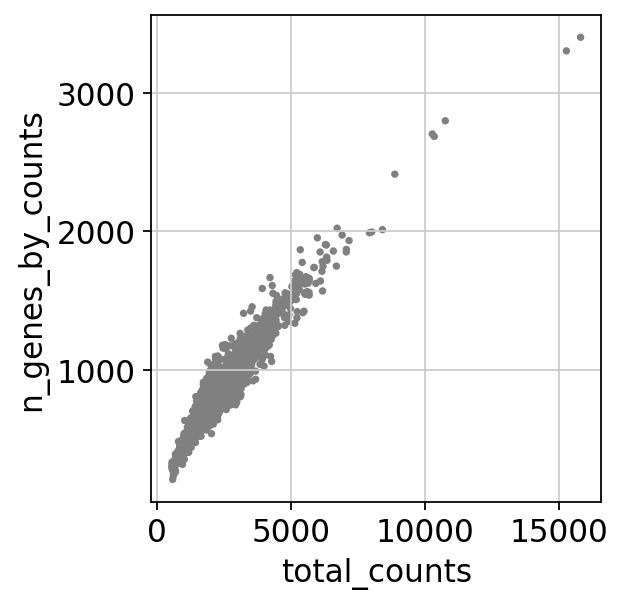

In [10]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [11]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()


In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [13]:
sc.pp.log1p(adata)

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


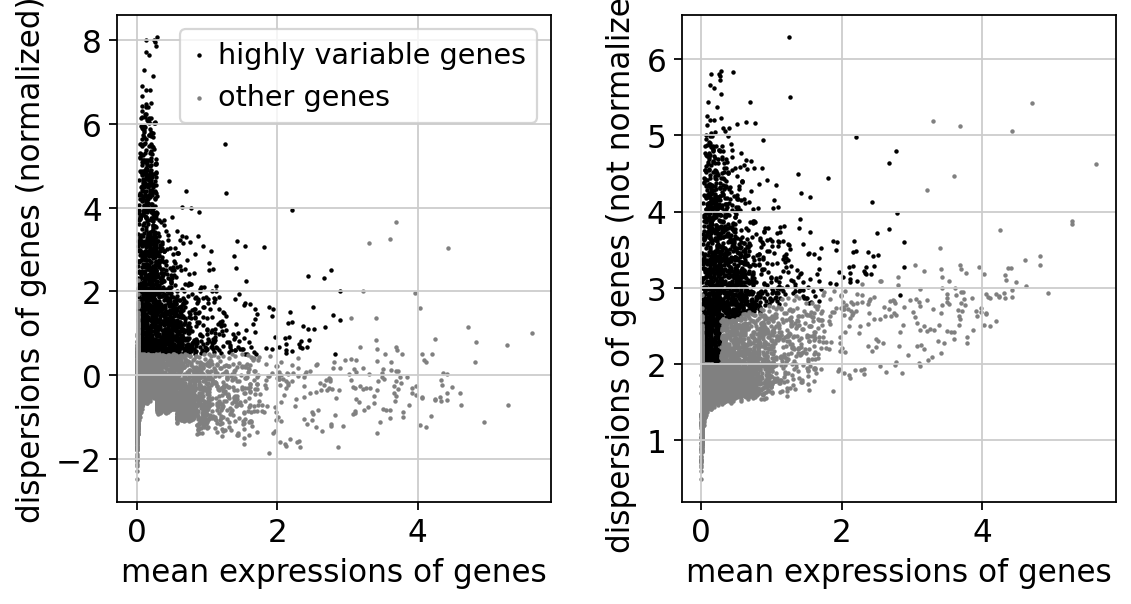

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
print("Found", adata.var['highly_variable'].sum(), "highly variable genes")

Found 1838 highly variable genes


> Unnecessary if not correcting the data with `sc.pp.regress_out` or scaling it `via sc.pp.scale`

In [17]:
# Freezes the normalized and log'ed into raw
adata.raw = adata

> The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step below is unnecessary, too.

In [18]:
# Filter out non-highly-variable genes
adata = adata[:, adata.var.highly_variable]

In [19]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/zata/zippy/kresgeb/Miniforge3/envs/main/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:04)


In [20]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [21]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


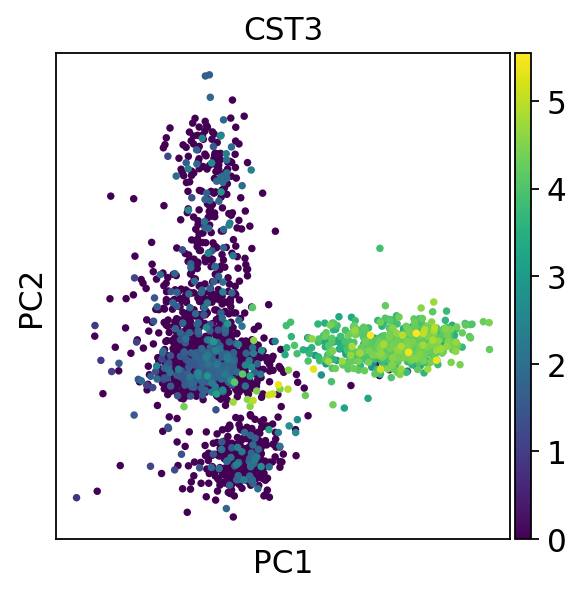

In [22]:
# We can make a scatter plot in the PCA coordinates, but we will not use that later on.
sc.pl.pca(adata, color="CST3")

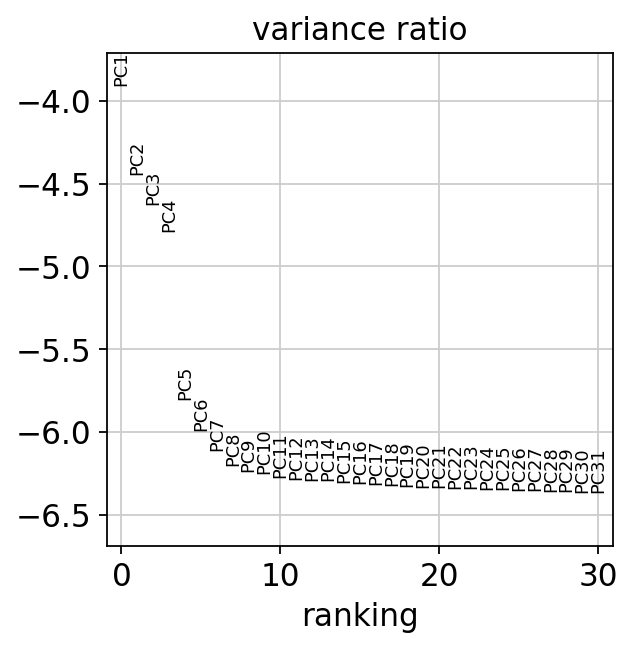

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)


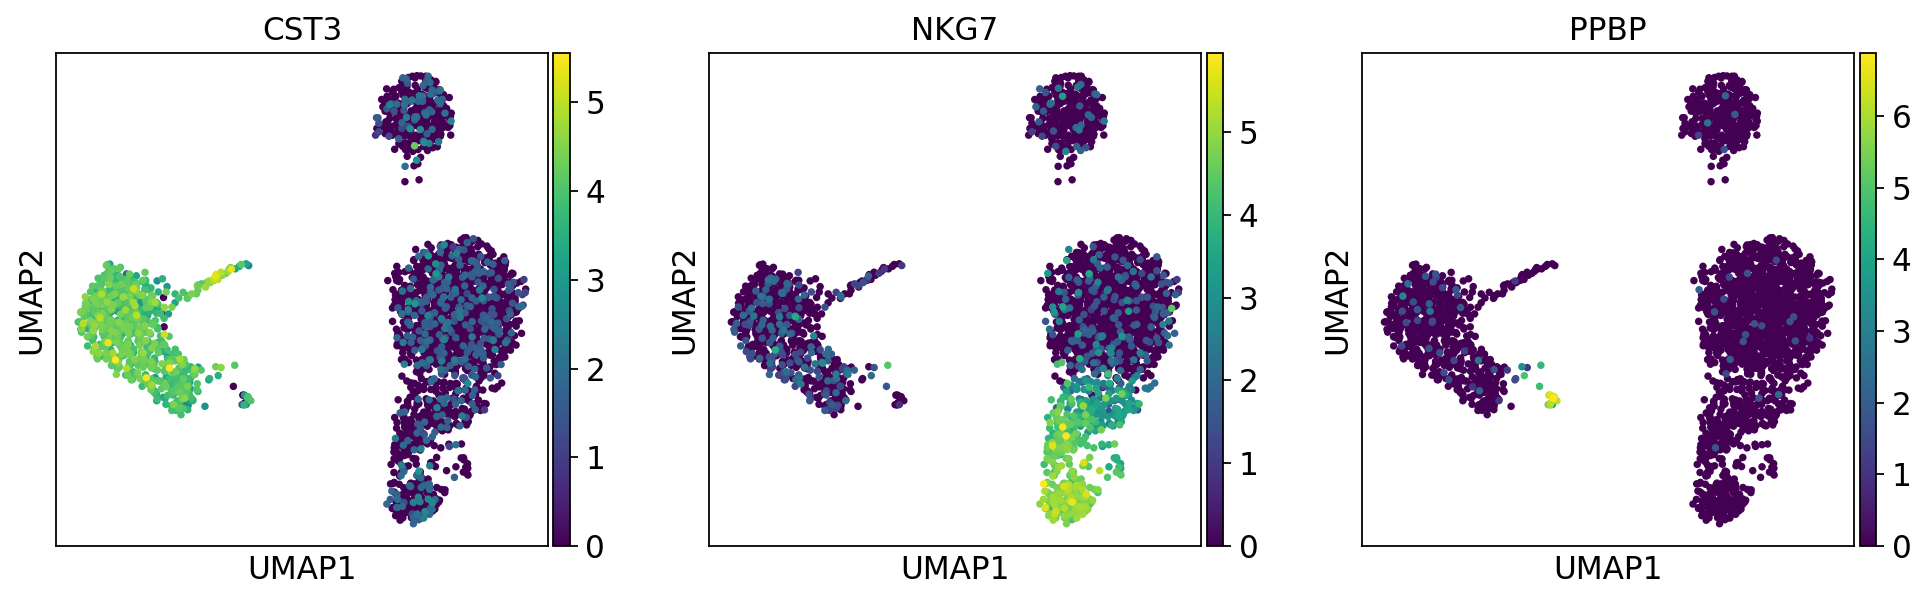

Above: normalized and logarithmized, but UNCORRECTED (no regress-out or scaling), Below: same with addition of regress-out and scaling


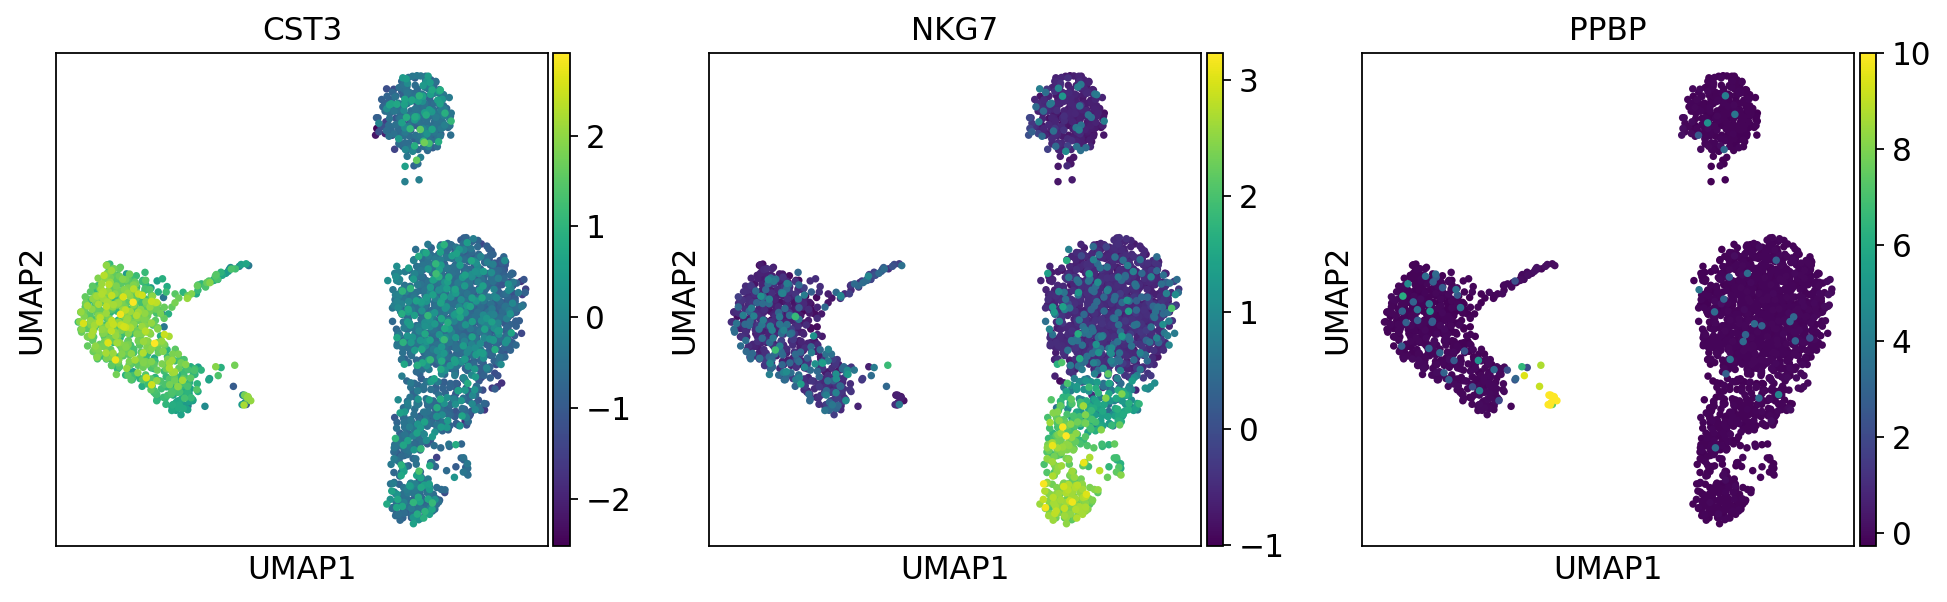

In [25]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])
print("Above: normalized and logarithmized, but UNCORRECTED (no regress-out or scaling), Below: same with addition of regress-out and scaling")
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

In [26]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


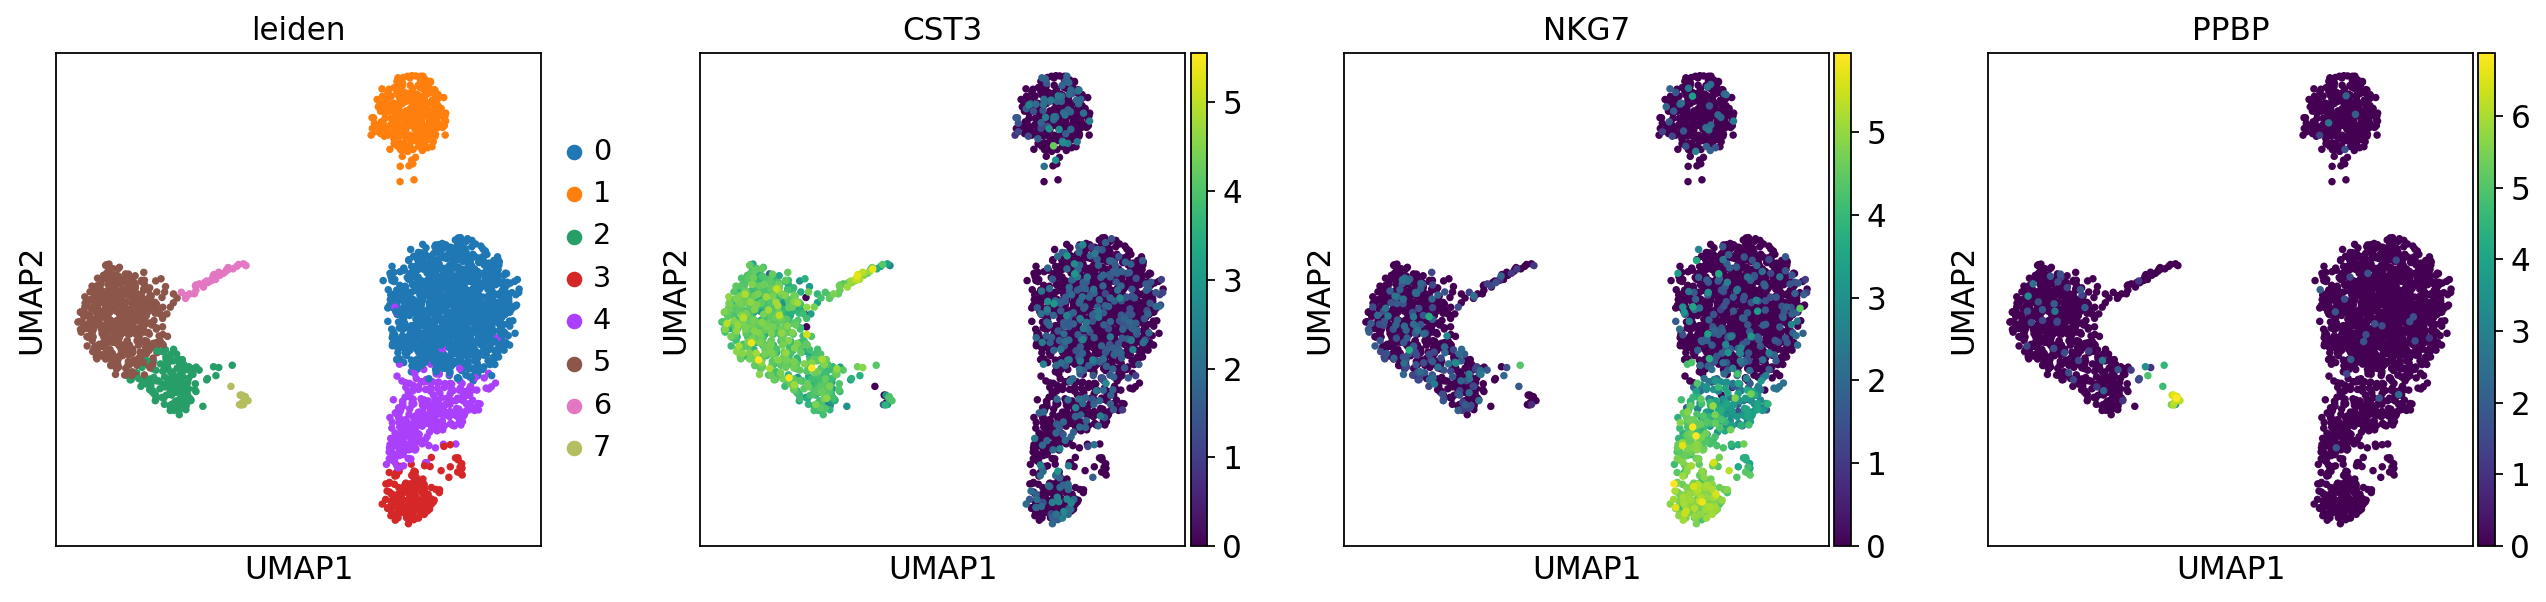

In [27]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7", "PPBP"])

In [28]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


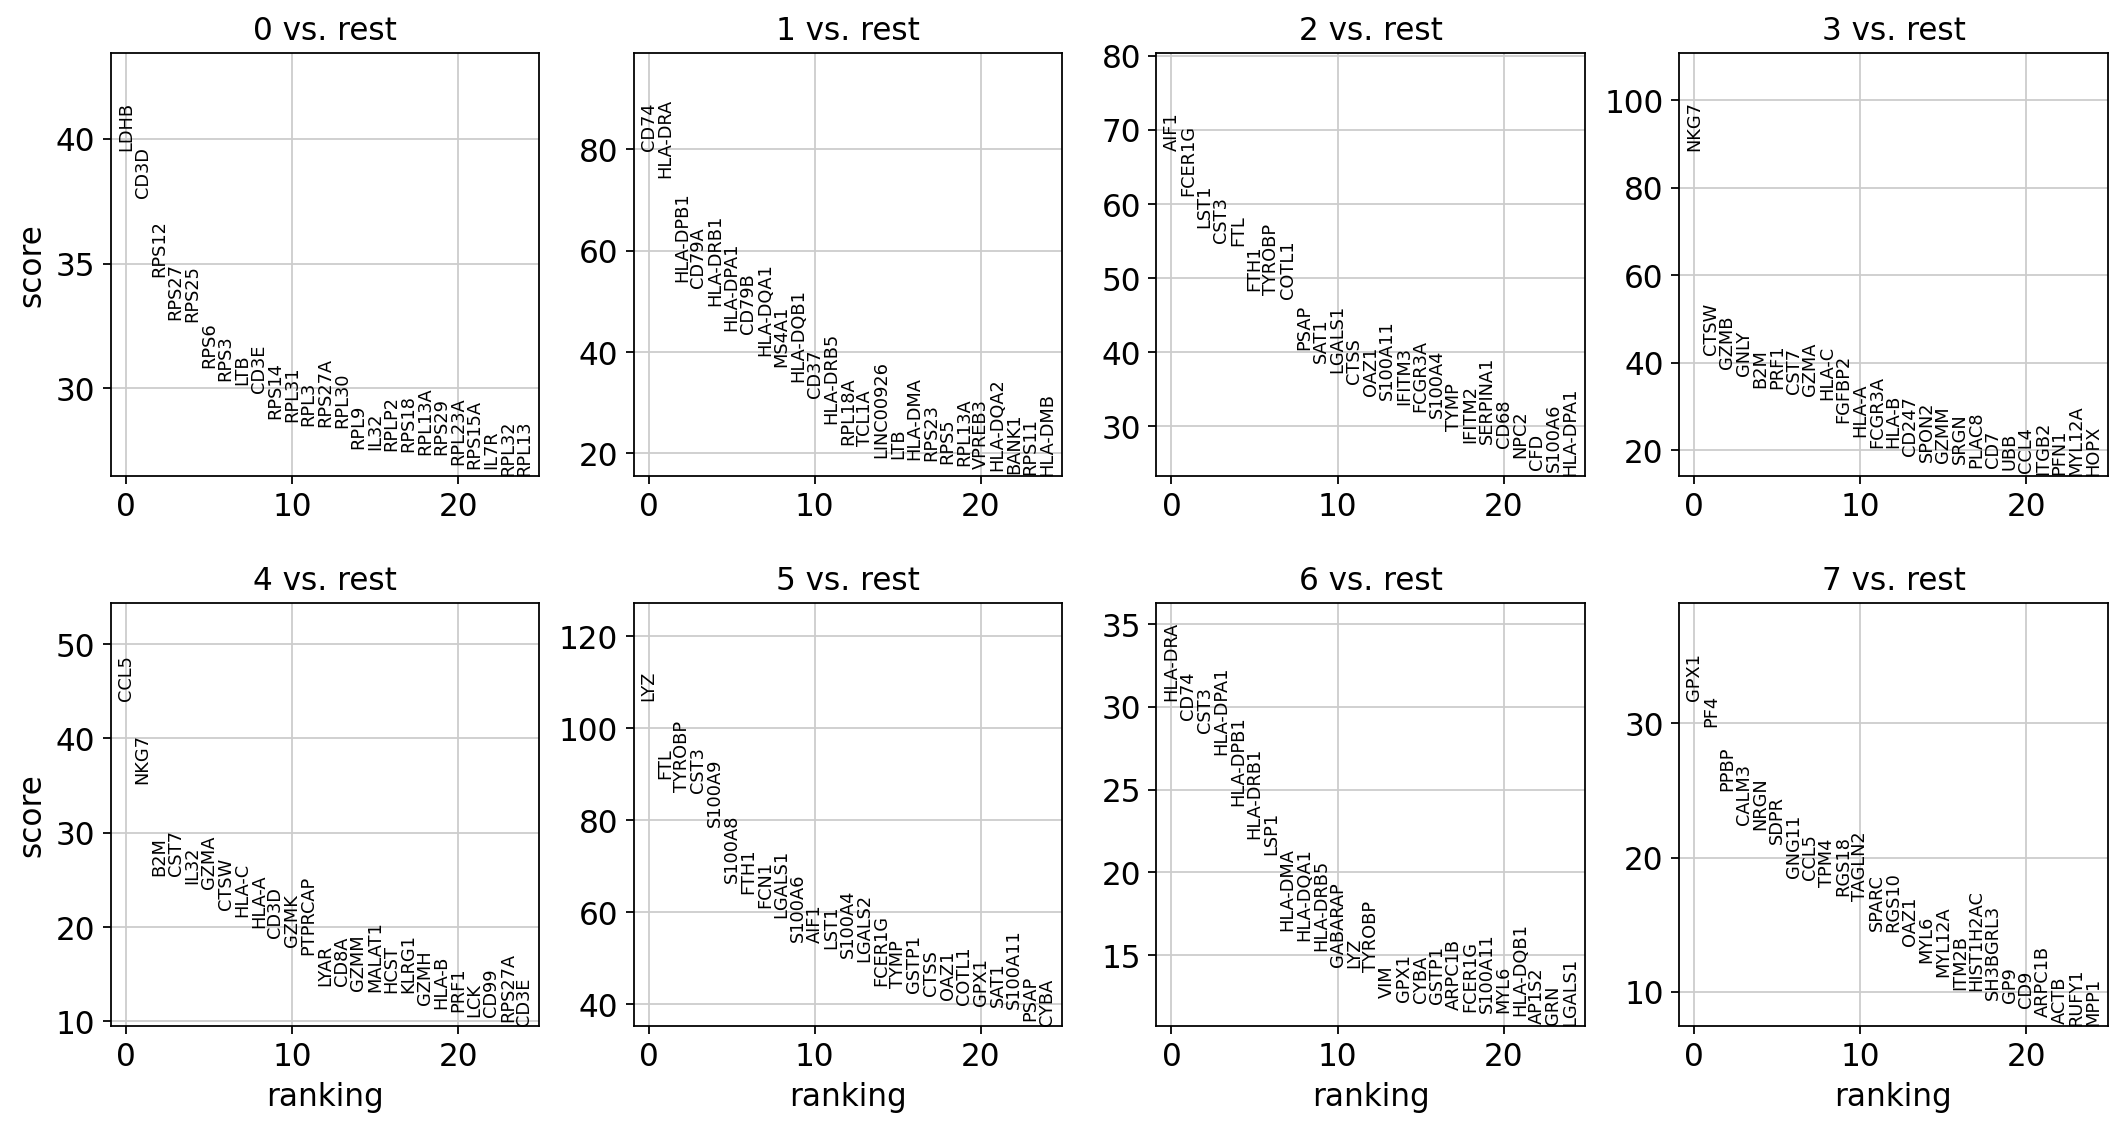

In [29]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


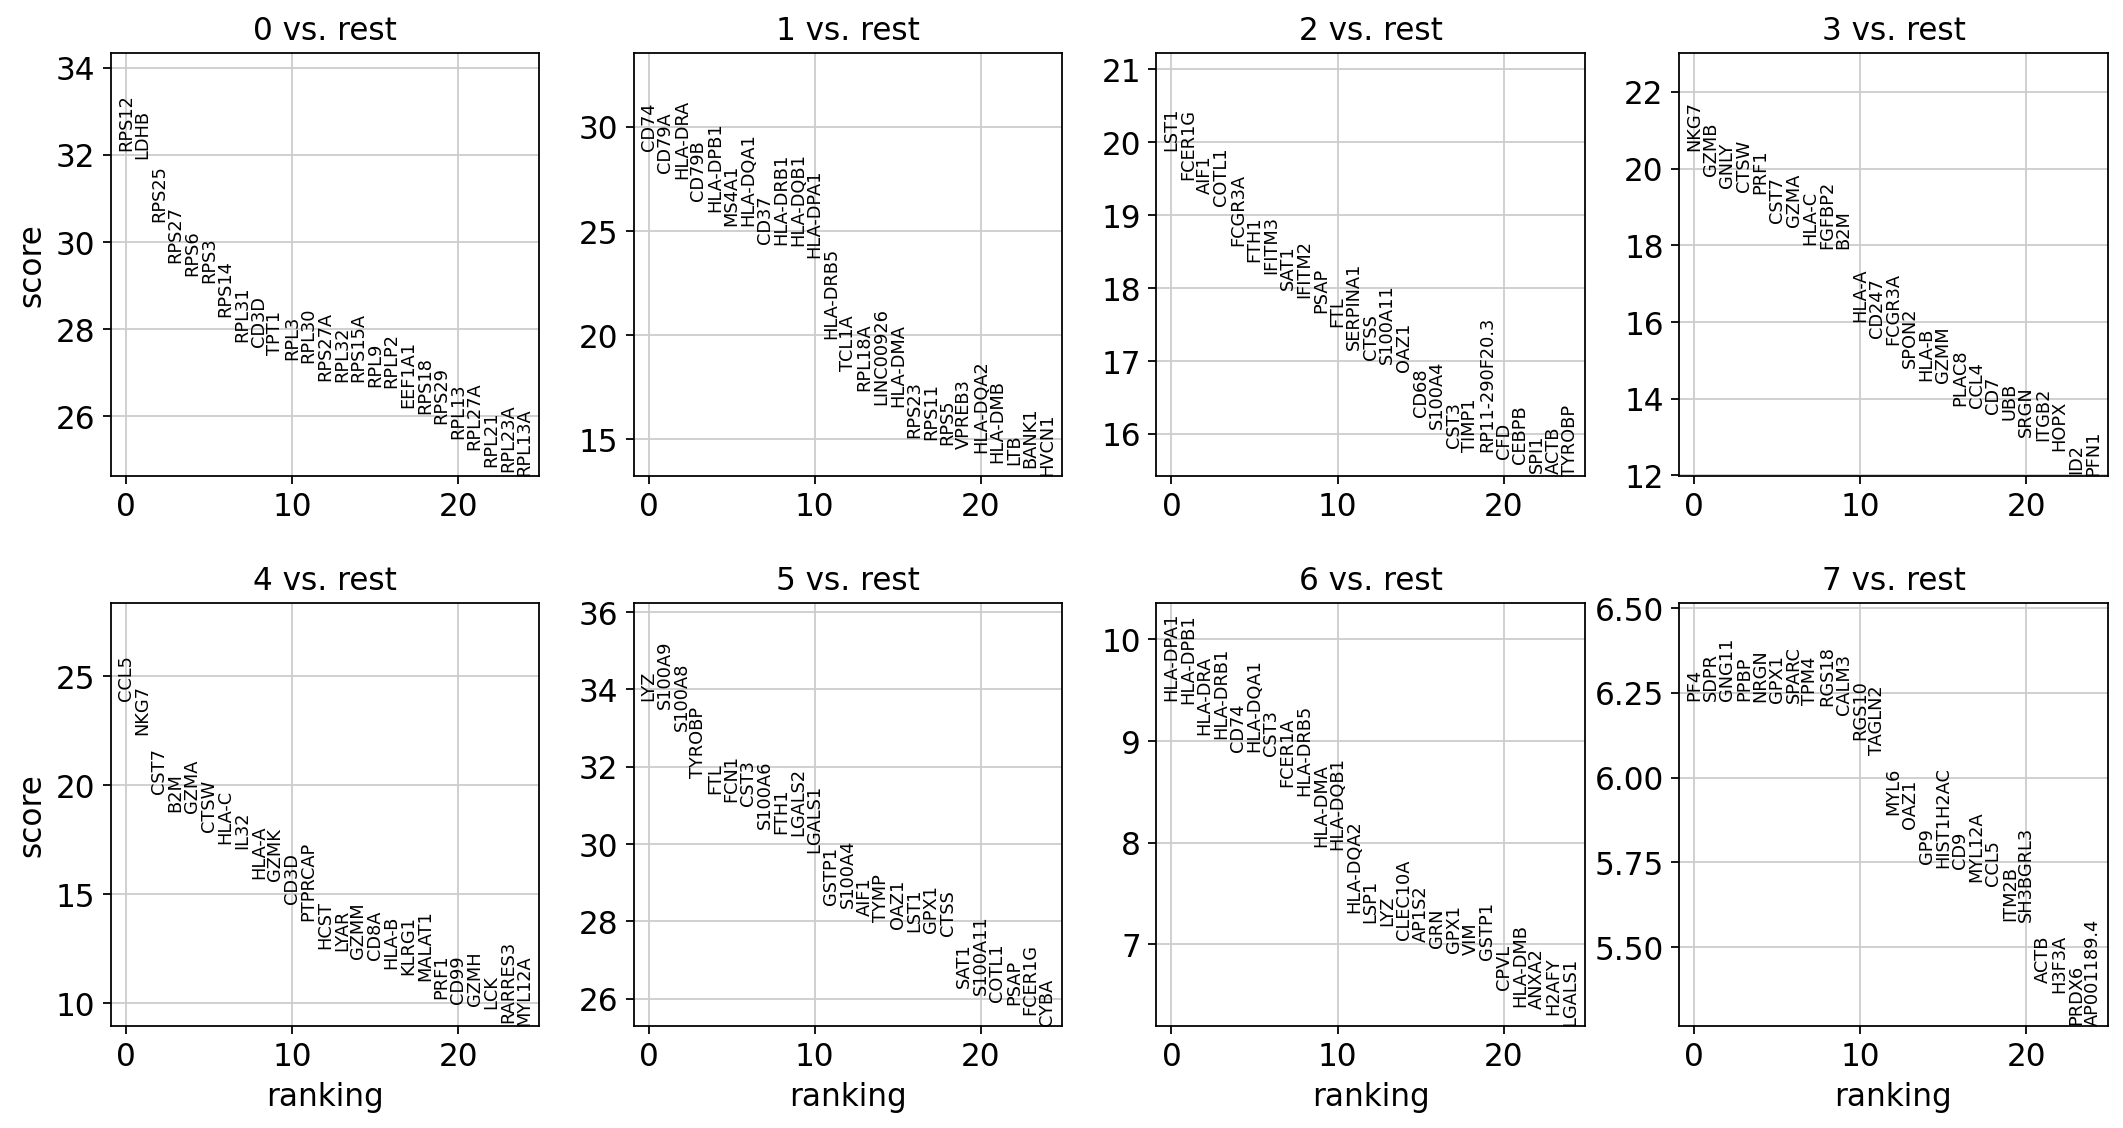

In [30]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:04)


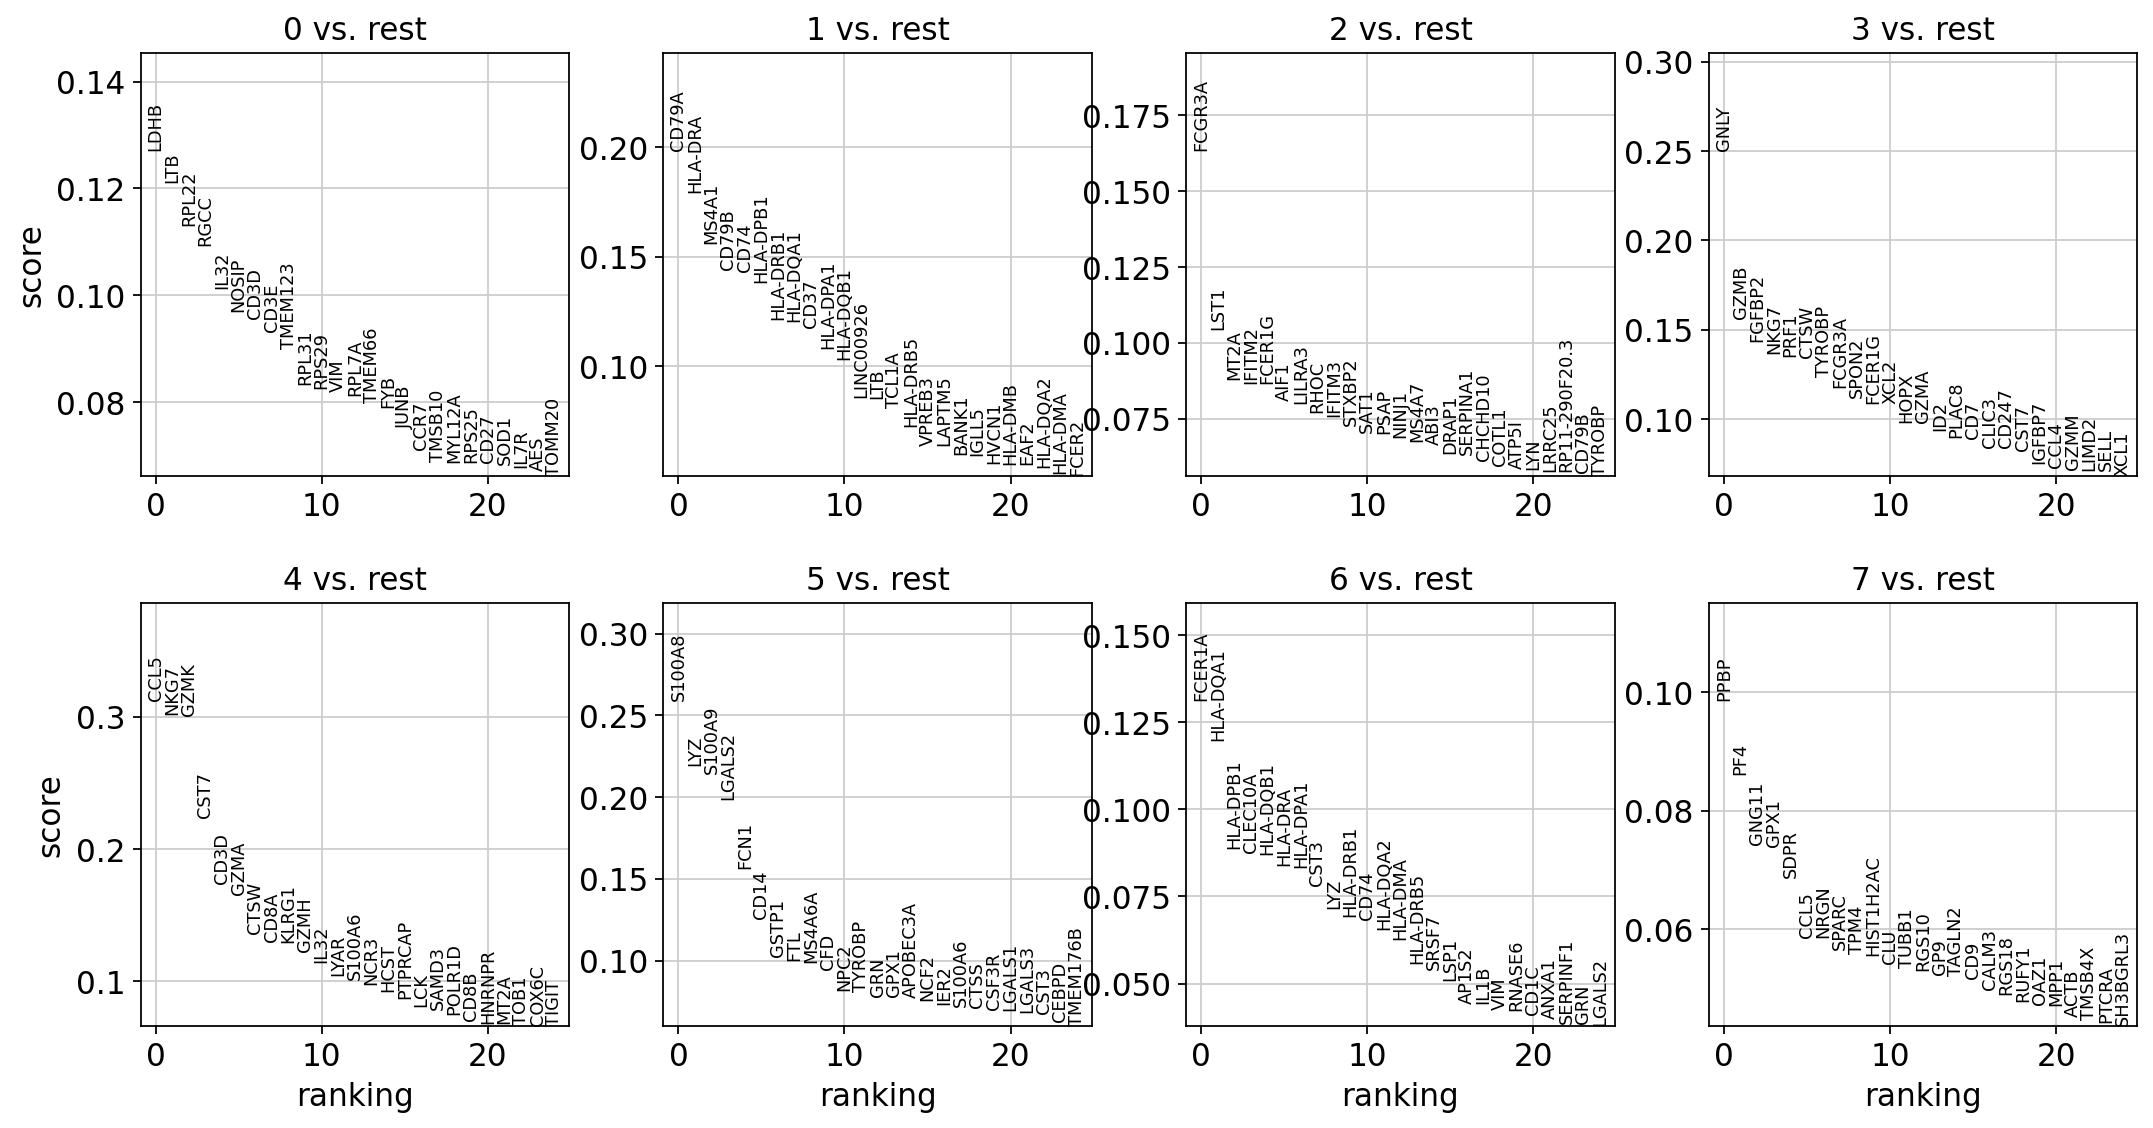

In [31]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

> Any good options for DE Testing in python? Or should I use R for this? If I use R, how to integrate into python?

## Task 2: Deep-Sequencing Data

> ### TODO: try comparing replicates to  each other, and verify that the "Sig" TF's and merged TF's are the same magnitude
> -----
> - Follow through as written
> - try only rep1/rep2
> - MAYBE try to average them (extra credit)

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyBigWig
import multiprocessing
from functools import partial


path_to_data = "/data/projects/gsjc/Thurman_Nature_2012/figure2b"

output_dir = "/data/zusers/kresgeb/output"
os.makedirs(output_dir, exist_ok=True)

scratch_dir = "/zata/zippy/kresgeb/scratch"
os.makedirs(scratch_dir, exist_ok=True)

# Paths to files
dnase_peak_files = [
    "wgEncodeUwDnaseK562PkRep1.narrowPeak",
    "wgEncodeUwDnaseK562PkRep2.narrowPeak",
]
dnase_signal_files = [
    "wgEncodeUwDnaseK562RawRep1.bigWig",
    "wgEncodeUwDnaseK562RawRep2.bigWig",
]


# All the chip signal files
chip_signal_files = [f for f in os.listdir(path_to_data) if f.endswith(".bigWig") and "Dnase" not in f]
chip_signal_files.sort() # we want Rep1 to always come before Rep2 so we can use that assumption later


# Identify replicates and insert into dict with name as key
tf_replicates = {}
for chip_signal_file in chip_signal_files:
    # Only operate on replicates
    if "RawRep" in chip_signal_file:
        tf_name = chip_signal_file.split("RawRep")[0]
        if tf_name not in tf_replicates:
            tf_replicates[tf_name] = []
        tf_replicates[tf_name].append(chip_signal_file)

# Select only Rep1
finalized_chip_signal_files = [os.path.join(path_to_data, f) for f in chip_signal_files if f.endswith("Sig.bigWig")]
for tf_name, files in tf_replicates.items():
    finalized_chip_signal_files.append(os.path.join(path_to_data, files[0]))

# Merge the reps using bigWigMerge
# finalized_chip_signal_files = [os.path.join(path_to_data, f) for f in chip_signal_files if f.endswith("Sig.bigWig")]
# TODO: Implement (merge makes a BedGraph, which needs a chrom.sizes to convert back into a BigWig)

    
peak_df = pd.read_csv(os.path.join(path_to_data, dnase_peak_files[0]),
                      sep='\t',
                      header=None,
                      usecols=[0, 1, 2, 7],
                      names=['chrom', 'start', 'end', 'signal'],
                     )

peaks_list = list(peak_df[['chrom', 'start', 'end']].itertuples(index=False, name=None))
print(f"{len(peaks_list)} peaks found")

# print(peak_df.head(20))


def process_file(bw_path, peaks):
    file_name = os.path.basename(bw_path)  # Extract file name for DataFrame column
    results = []
   # print(f"Processing {file_name}")
    try:
        with pyBigWig.open(bw_path) as bw:
            for chrom, start, end in peaks:
                mean_signal = bw.stats(chrom, start, end)[0]
                results.append(mean_signal if mean_signal is not None else 0.0)
    except Exception as e:
        print(f"Error processing {bw_path}: {e}")
        results = [0.0] * len(peaks)  # Default to zeros in case of error
    # print(f"Finished processing {file_name}")
    return results
    
df = pd.DataFrame({"Peak": [f"{chrom}:{start}-{end}" for chrom, start, end in peaks_list]})

pool = multiprocessing.Pool(processes=30)
process_file_partial = partial(process_file, peaks=peaks_list)
results = pool.map(process_file_partial, finalized_chip_signal_files)

for i, file in enumerate(finalized_chip_signal_files):
    df[os.path.basename(file)] = results[i]
tf_columns = [col for col in df.columns if col != "Peak" and col != "DNase"]  # List of TF columns
df["ChIP"] = df[tf_columns].sum(axis=1)
df["DNase"] = process_file(os.path.join(path_to_data, dnase_signal_files[0]), peaks_list)
df["ChIP"] = np.log2(df["ChIP"] + 0.001)
df["DNase"] = np.log2(df["DNase"] + 0.001)



142986 peaks found
Finished processing wgEncodeSydhTfbsK562E2f6UcdSig.bigWig
Finished processing wgEncodeSydhTfbsK562Rfx5IggrabSig.bigWig
Finished processing wgEncodeHaibTfbsK562Egr1V0416101RawRep1.bigWig
Finished processing wgEncodeSydhTfbsK562Nfe2StdSig.bigWig
Finished processing wgEncodeSydhTfbsK562CtcfbIggrabSig.bigWig
Finished processing wgEncodeSydhTfbsK562CmycStdSig.bigWig
Finished processing wgEncodeSydhTfbsK562MaffIggrabSig.bigWig
Finished processing wgEncodeSydhTfbsK562MaxStdSig.bigWig
Finished processing wgEncodeSydhTfbsK562P300IggrabSig.bigWig
Finished processing wgEncodeSydhTfbsK562Brg1IggmusSig.bigWig
Finished processing wgEncodeSydhTfbsK562JundIggrabSig.bigWig
Finished processing wgEncodeSydhTfbsK562Ccnt2StdSig.bigWig
Finished processing wgEncodeSydhTfbsK562Bhlhe40nb100IggrabSig.bigWig
Finished processing wgEncodeSydhTfbsK562Znf143IggrabSig.bigWig
Finished processing wgEncodeSydhTfbsK562CebpbIggrabSig.bigWig
Finished processing wgEncodeSydhTfbsK562CfosStdSig.bigWig
Finis

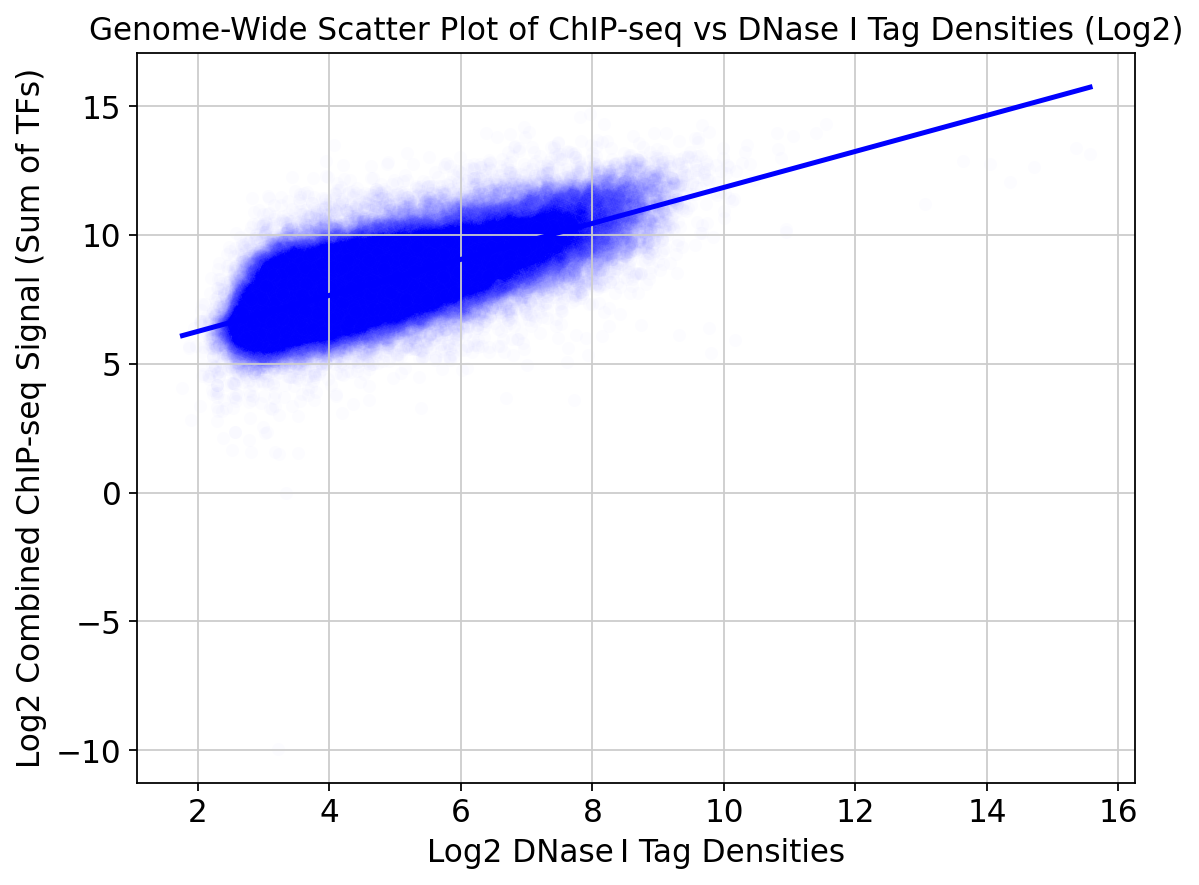

In [33]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="DNase", y="ChIP", data=df, color='blue', alpha=0.01)
sns.regplot(x="DNase", y="ChIP", data=df, scatter=False, color="blue")
plt.xlabel("Log2 DNase I Tag Densities")
plt.ylabel("Log2 Combined ChIP-seq Signal (Sum of TFs)")
plt.title("Genome-Wide Scatter Plot of ChIP-seq vs DNase I Tag Densities (Log2)")
plt.show()

## Figure 3b, Avg Signal of DNase 1 and H3Kme3 compared to TSSs across multiple Cell Types

In [34]:
# Create the directory if it doesn't exist and change into it
os.makedirs("/zata/zippy/kresgeb/Onboard/data", exist_ok=True)
os.chdir("/zata/zippy/kresgeb/Onboard/data")

# Check if the annotation file exists; if not, download it
if not os.path.exists("gencode.v7.annotation.gtf.gz"):
    print("Downloading annotation file...")
    ! wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_7/gencode.v7.annotation.gtf.gz
else:
    print("Annotation file already exists.")

# Check if the transcript_entries.tsv file exists; if not, extract and create it
if not os.path.exists("transcript_entries.tsv"):
    print("Extracting transcript entries...")

    !zgrep -w "protein_coding" gencode.v7.annotation.gtf.gz | awk -F'\t' '$3 == "transcript" && $9 ~ /gene_type "protein_coding"/ && $9 ~ /transcript_type "protein_coding"/' > transcript_entries.tsv
    
    print("Transcript entries saved to transcript_entries.tsv.")
else:
    print("transcript_entries.tsv already exists.")


Annotation file already exists.
transcript_entries.tsv already exists.


In [35]:
transcript_df = pd.read_csv( 'transcript_entries.tsv',
                      sep='\t',
                      header=None,
                      usecols=[0, 3, 4, 6],
                      names=['chrom', 'start', 'end', 'strand'],
                     )

def average_tss_window_from_file(bw_path, width=400, transcript_df=transcript_df):
    """
    Extract TSS windows from a BigWig file for the given transcript DataFrame, then average them.

    Parameters:
        bw_path (str): Path to the BigWig file.
        width (int): Half the window size to extract, i.e., ± width (full window will be 2 * width + 1).
        transcript_df (pd.DataFrame): DataFrame with columns ['chrom', 'start', 'end', 'strand'].

    Returns:
        np.ndarray: A 1D numpy array containing the averaged values of all TSS windows.
    """
    import pyBigWig
    import numpy as np

    # Initialize a list to store the extracted windows
    tss_windows = []

    # Open the BigWig file
    with pyBigWig.open(bw_path) as bw:
        for _, row in transcript_df.iterrows():
            chrom = row['chrom']
            strand = row['strand']
            tss = row['start'] if strand == '+' else row['end']  # Determine TSS based on strand

            # Calculate the window boundaries
            start = max(0, tss - width)  # Ensure start is not negative
            end = tss + width + 1  # +1 because BigWig is end-exclusive

            # Check if the chromosome and interval are valid
            if chrom not in bw.chroms():
                continue

            chrom_length = bw.chroms(chrom)  # Get the chromosome length
            if end > chrom_length:
                end = chrom_length

            # Fetch the values from the BigWig file
            try:
                values = bw.values(chrom, start, end, numpy=True)
                #values = np.nan_to_num(values)  # Replace NaN values with 0
            except RuntimeError as e:
                print(f"Error fetching values for {chrom}:{start}-{end}: {e}")
                continue

            # Reverse the values if the strand is '-'
            if strand == '-':
                values = values[::-1]

            # Append the values to the list
            tss_windows.append(values)

    # Convert the list of windows to a numpy array
    tss_windows = np.array(tss_windows)

    # Average the windows across all rows (ignore NaNs)
    if len(tss_windows) > 0:
        averaged_values = np.nanmean(tss_windows, axis=0)  # Averaging across rows
    else:
        print(f"Warning: error averaging TSS windows for {bw_path}")
        averaged_values = np.zeros(2 * width + 1)  # Return a zero array if no windows are found
    # print(f"Finished processing {os.path.basename(bw_path)}")
    return averaged_values

In [36]:
from tqdm import tqdm
def process_tss_windows_from_directory(directory, allow_reps=True, width=400):
    """
    Processes all BigWig files in the directory and returns a DataFrame where each row corresponds
    to a BigWig file, with columns for the TSS window (size = 2*width + 1).
    
    Parameters:
        directory (str): Directory containing BigWig files.
        allow_reps (bool): If True, include files with replicate information (RawRep1, RawRep2 in filenames).
        width (int): Half of the window size around the TSS (full window = 2*width + 1).
    
    Returns:
        pd.DataFrame: DataFrame where each row is a file and columns are the TSS window values.
    """
    # Get the list of BigWig files in the directory
    bigwig_files = [f for f in os.listdir(directory) if f.endswith(".bigWig")]
    
    # Create a Pool of processes to parallelize the work
    pool = multiprocessing.Pool(processes=30)
    full_file_paths = [os.path.join(directory, f) for f in bigwig_files]
    tss_windows = []
    # Use pool.map to apply the function to all files in parallel
    for window in tqdm(pool.imap(average_tss_window_from_file, full_file_paths), total=len(full_file_paths)):
        tss_windows.append(window)
    
    # Close the pool to free resources
    pool.close()
    pool.join()
    
    # Create a DataFrame with the results
    tss_window_df = pd.DataFrame(tss_windows, columns=np.arange(-width, width + 1))
    
    # Add the file names as an additional column (index)
    tss_window_df['file_name'] = bigwig_files
    
    # Set file_name as the index of the DataFrame
    tss_window_df.set_index('file_name', inplace=True)

    return tss_window_df

    
dnase_csv_path = "/zata/zippy/kresgeb/Onboard/data/dnase_df.csv"
h3k4me3_csv_path = "/zata/zippy/kresgeb/Onboard/data/h3k4me3_df.csv"

# Check if the DNase DataFrame CSV exists
if os.path.exists(dnase_csv_path):
    dnase_df = pd.read_csv(dnase_csv_path, index_col=0)  # Read CSV if it exists
    print(f"Loaded DNase DataFrame from {dnase_csv_path}")
else:
    # Process the TSS windows and save the result to CSV if the file doesn't exist
    dnase_df = process_tss_windows_from_directory("/data/projects/gsjc/Thurman_Nature_2012/figure3b/dnase_signal")
    dnase_df.to_csv(dnase_csv_path, index=True)  # Save to CSV
    print(f"Processed and saved DNase DataFrame to {dnase_csv_path}")

# Check if the H3K4Me3 DataFrame CSV exists
if os.path.exists(h3k4me3_csv_path):
    h3k4me3_df = pd.read_csv(h3k4me3_csv_path, index_col=0)  # Read CSV if it exists
    print(f"Loaded H3K4Me3 DataFrame from {h3k4me3_csv_path}")
else:
    # Process the TSS windows and save the result to CSV if the file doesn't exist
    h3k4me3_df = process_tss_windows_from_directory("/data/projects/gsjc/Thurman_Nature_2012/figure3b/h3k4me3_signal")
    h3k4me3_df.to_csv(h3k4me3_csv_path, index=True)  # Save to CSV
    print(f"Processed and saved H3K4Me3 DataFrame to {h3k4me3_csv_path}")


100%|█████████████████████████████████████████████████████████████████████████████████| 109/109 [00:52<00:00,  2.07it/s]


Processed and saved DNase DataFrame to /zata/zippy/kresgeb/Onboard/data/dnase_df.csv


100%|█████████████████████████████████████████████████████████████████████████████████| 106/106 [00:50<00:00,  2.10it/s]


Processed and saved H3K4Me3 DataFrame to /zata/zippy/kresgeb/Onboard/data/h3k4me3_df.csv


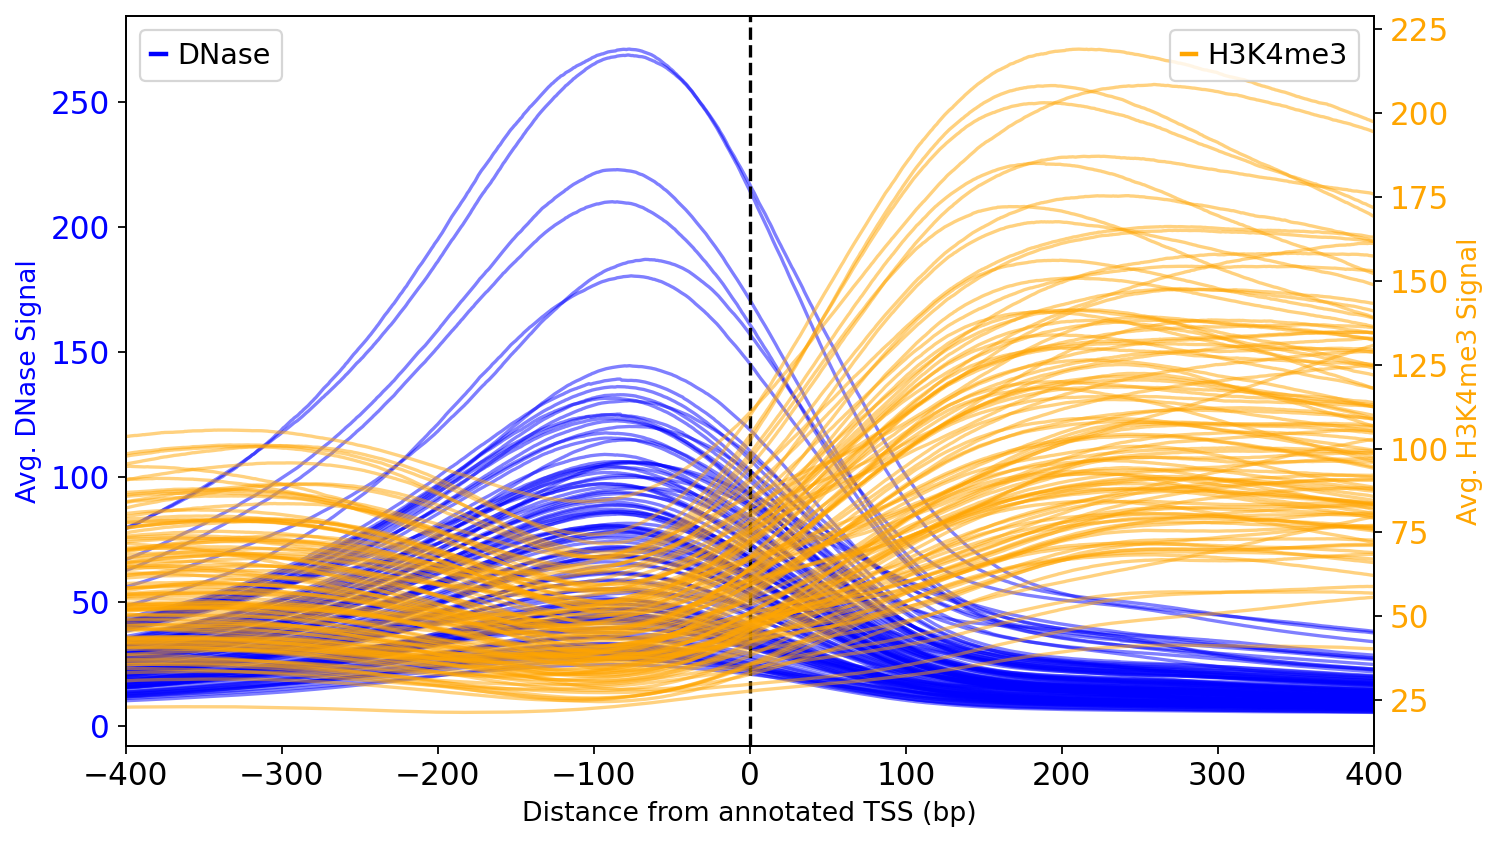

In [37]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot DNase signals for each file on the first y-axis (ax1)
for i, row in dnase_df.iterrows():
    ax1.plot(dnase_df.columns.astype(int), row, color='blue', alpha=0.5)  # DNase in blue

# Customize the first y-axis (for DNase)
ax1.set_xlabel("Distance from annotated TSS (bp)", fontsize=12)
ax1.set_ylabel("Avg. DNase Signal", fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Set x-axis range and ticks
ax1.set_xlim(-400, 400)  # Limit the x-axis to show from -400 to +400 bp
ax1.set_xticks(range(-400, 401, 100))  # From -400 to +400 with a step of 100

# Create a second y-axis (for H3K4me3)
ax2 = ax1.twinx()

# Plot H3K4me3 signals for each file on the second y-axis (ax2)
for i, row in h3k4me3_df.iterrows():
    ax2.plot(h3k4me3_df.columns.astype(int), row, color='orange', alpha=0.5)  # H3K4me3 in red

# Customize the second y-axis (for H3K4me3)
ax2.set_ylabel("Avg. H3K4me3 Signal", fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add TSS line at offset 0
ax1.axvline(x=0, color='black', linestyle='--', label="TSS")

# Set legend manually to avoid confusion
ax1.legend([plt.Line2D([0], [0], color='blue', lw=2)], ["DNase"], loc='upper left')
ax2.legend([plt.Line2D([0], [0], color='orange', lw=2)], ["H3K4me3"], loc='upper right')


ax1.grid(False)
ax2.grid(False)

# Show the plot
plt.show()